# Clustering: Global Terrorism

## Introduction

Terrorism has been a topic in political discourse for as long as I can remember. As I was looking through data to work on, this stuck out to me, as well as a few ideas on trends I could analyze involving it, which led to what you see here. The [dataset](https://www.kaggle.com/datasets/START-UMD/gtd) covers historical records of terrorist incidents, from 1970 to 2017, maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism, which can be found [here](https://www.start.umd.edu/gtd/). The site is updated to 2020, but I chose the dataset from Kaggle due to the fact that they may have done some of the prepwork for me.

For this report, I'm going to use clustering to focus on <strong>the time when attacks occur, and when those are more likely to occur</strong>. I chose this specific topic due to the benefit that it could provide to affected areas, and also because of personal interest.

### What is Data Clustering?

Clustering is where a model takes a set of data and groups it with other data based on similarity. For example, regarding the above, the terrirosm dataset could be grouped based on weapon type, with attacks A, B, and C being different kinds of weapons. There are multiple types of clustering, such as K-means or Agglomerative clustering.

### The Data

I'm mainly going to be focusing on the overlap betweeen times and dates, as well as when and where attacks occured in those dates. As you'll see throughout this report, the respective columns in the dataset will be pulled or created to match those specific focuses. I'll then use k-means clustering to possibly identify trends that weren't noticed before, and hopefully pull some observations from those trends.

## Visualizing Data before Clustering

The data cleaning here is going to focus on temporal clustering.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

In [6]:
terror_df = pd.read_csv('data/gtd.csv', encoding='ISO-8859-1', low_memory=False)

terror_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


The initial goal of cleaning here is to correlate the time and location of these attacks. We will do so by implementing the code below:

In [7]:
#filter columns
time_location_corr_df = terror_df[['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'latitude', 'longitude']].copy()

#filter rows with missing values
time_location_corr_df = time_location_corr_df.dropna(subset=['iyear', 'imonth', 'iday'])

#convert columns to integers
time_location_corr_df['year'] = time_location_corr_df['iyear'].astype(int)
time_location_corr_df['month'] = time_location_corr_df['imonth'].astype(int)
time_location_corr_df['day'] = time_location_corr_df['iday'].astype(int)

#create a combined date column
time_location_corr_df['date'] = pd.to_datetime(
    time_location_corr_df[['year', 'month', 'day']], errors='coerce'
)

#drop rows with invalid dates
time_location_corr_df.dropna(subset=['date'], inplace=True)

#group data by location and time
grouped_data = time_location_corr_df.groupby(['date', 'country_txt', 'region_txt']).size().reset_index(name='attack_count')

### Modeling

With the data we have above, it would take all the data from 1970 and display every country within that data, which isn't very readable, and put it in a readable format. I'm going to summarize the data using the top 5 regions and the top 15 years, and make a heatmap using that data.

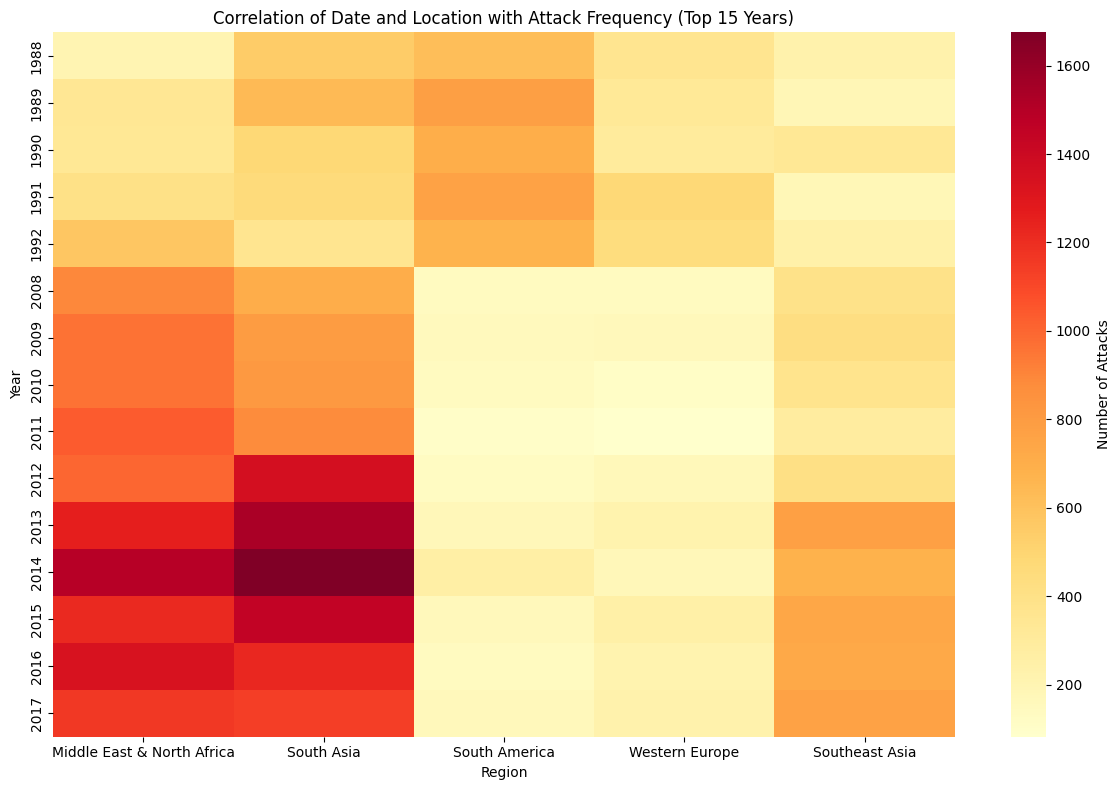

In [8]:
heatmap_data_model1 = grouped_data.pivot_table(
    index='date',
    columns='region_txt',
    values='attack_count',
    fill_value=0
)

#make sure the index is a datetime object and extract the year
if not pd.api.types.is_datetime64_any_dtype(heatmap_data_model1.index):
    heatmap_data_model1.index = pd.to_datetime(heatmap_data_model1.index, errors='coerce')

heatmap_data_model1.index = heatmap_data_model1.index.year

#aggregate data by year, sum number of attacks
heatmap_data_model1 = heatmap_data_model1.groupby(heatmap_data_model1.index).sum()

#select top 5 regions by attack frequency
top_regions_model1 = heatmap_data_model1.sum().nlargest(5).index
heatmap_data_reduced_model1 = heatmap_data_model1[top_regions_model1]

#select top 15 years by attack frequency
top_years_model1 = heatmap_data_reduced_model1.sum(axis=1).nlargest(15).index

#sort chronologically for readability
top_years_sorted_model1 = sorted(top_years_model1)
heatmap_data_reduced_model1 = heatmap_data_reduced_model1.loc[top_years_sorted_model1]

#plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data_reduced_model1, cmap='YlOrRd', cbar_kws={'label': 'Number of Attacks'})
plt.title('Correlation of Date and Location with Attack Frequency (Top 15 Years)')
plt.xlabel('Region')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


Next, instead of sorting by the highest 15 years, I wanted to sort by the most recent 10 years for relevant data, as well as using the top 10 countries instead of the top 5.

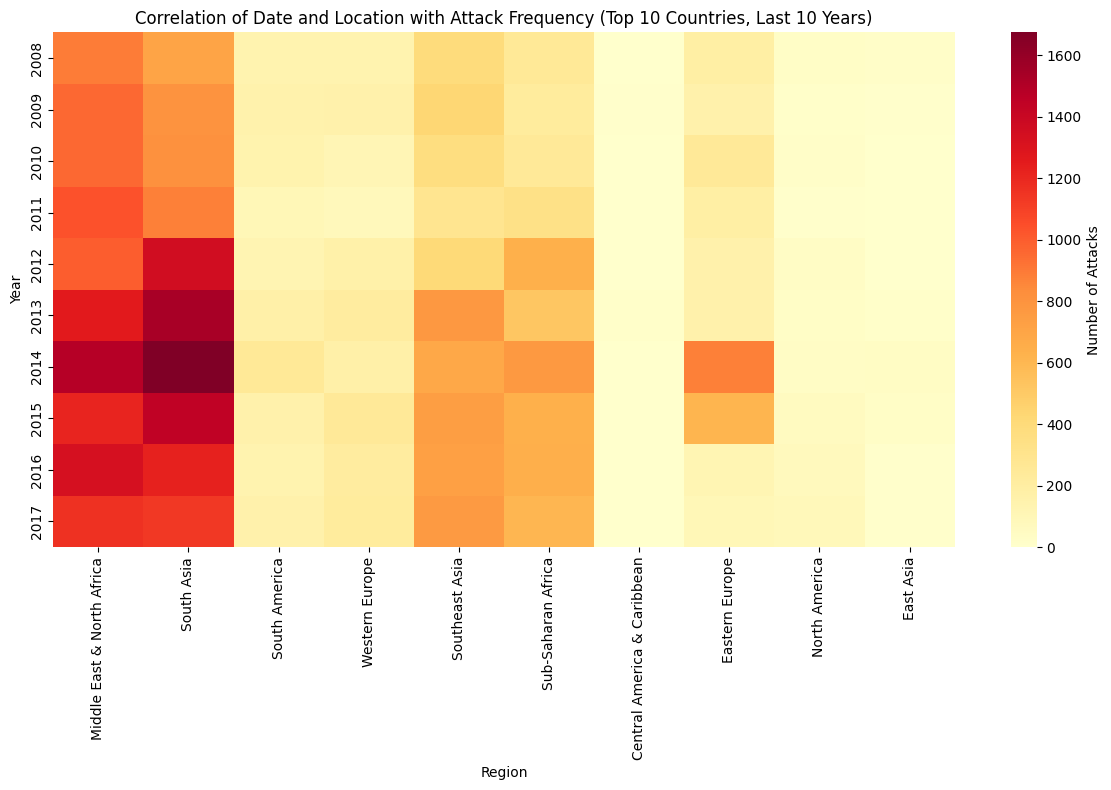

In [9]:
#note: a lot of this codeblock is AI-generated, due to how difficult it was to display the exact thing I wanted on the heatmap.

heatmap_data_model2 = grouped_data.pivot_table(
    index='date',
    columns='region_txt',
    values='attack_count',
    fill_value=0
)

#select top 10 regions by attack frequency
top_countries_model2 = heatmap_data_model2.sum().nlargest(10).index
heatmap_data_reduced_model2 = heatmap_data_model2[top_countries_model2]

#make sure the index is a datetime object and extract the year
if not pd.api.types.is_datetime64_any_dtype(heatmap_data_reduced_model2.index):
    heatmap_data_reduced_model2.index = pd.to_datetime(heatmap_data_reduced_model2.index, errors='coerce')

heatmap_data_reduced_model2.index = heatmap_data_reduced_model2.index.year

#aggregate data by year, sum number of attacks (instead of displaying as individual years)
heatmap_data_reduced_model2 = heatmap_data_reduced_model2.groupby(heatmap_data_reduced_model2.index).sum()

#select last 10 years
last_10_years_model2 = sorted(heatmap_data_reduced_model2.index.unique())[-10]
heatmap_data_last_10_years_model2 = heatmap_data_reduced_model2.loc[heatmap_data_reduced_model2.index >= last_10_years_model2]

#plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data_last_10_years_model2, cmap='YlOrRd', cbar_kws={'label': 'Number of Attacks'})
plt.title('Correlation of Date and Location with Attack Frequency (Top 10 Countries, Last 10 Years)')
plt.xlabel('Region')
plt.ylabel('Year')
plt.tight_layout()
plt.show()



### Initial Observations

- I had guessed based off my prior knowledge that the Middle East and North African region would be near the top, but I genuinely had no idea South Asia would be right up there with it, and seemingly pretty close as well
- It seems like South American and Western Europe's numbers have tapered off as of recently, being much higher in the 90's then they are today
- The dropoff from the top two to the lower numbers is a surprisingly stark difference

## Pre-Processing for Clustering

Instead of manually grouping the data as shown above, I'm going to use correlation and clustering to implement a model.

Component quantity to explain at least 90% variance: 16
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.109698 -2.355796  1.722993 -0.833603  0.973901  0.030902  0.044741   
1  3.900738 -1.870772  3.028331  0.286183 -0.446146  0.111781  0.502539   
2  1.476513 -2.940524  1.747851  1.358341 -0.554682  0.486425  0.174018   
3  1.142680 -2.957569  0.389567  1.073158 -0.530253  0.862457  0.271500   
4  1.572758 -2.841951  2.348504  0.826039 -0.817526  0.423462  0.328775   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.375147  0.191915 -1.537395 -0.182557  0.119255  0.318820 -1.119421   
1  1.121134 -1.699490 -1.612768 -0.079379  0.453218  0.564071 -0.869504   
2  0.974704 -1.426693 -1.713741  0.031431  0.338715  0.844483 -0.652555   
3  0.973311 -1.407502 -1.622576  0.245273  0.115772  0.936011  0.284420   
4  0.988428 -1.452125 -1.671199  0.021279  0.374188  0.879905 -0.044620   

       PC15      PC16  
0 -0.789758 -0.044

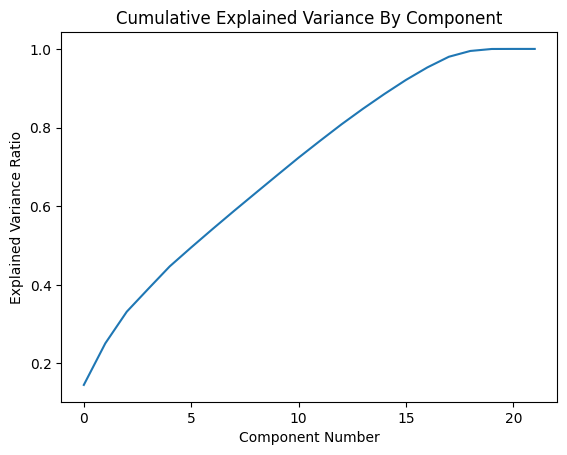

In [10]:
#step 1: create standardized dataframe
non_numeric_columns = terror_df.select_dtypes(exclude=['number']).columns

numeric_df = terror_df.drop(columns=non_numeric_columns)

#actual standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_df)

#convert standardized data to df
standardized_df = pd.DataFrame(standardized_data, columns=numeric_df.columns)

#drop NaN values
standardized_df.dropna(axis=1, inplace=True)

#step 2: dimensionality reduction
pca = PCA()
pca.fit(standardized_df)

#step 3: plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.plot(cumulative_explained_variance)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Cumulative Explained Variance By Component')

#step 4: reduce amount to components above 90%
num_components = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"Component quantity to explain at least 90% variance: {num_components}")

#apply pca with num_components
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(standardized_df)

#df for reduced data
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(num_components)])

#print reduced head to check results
print(reduced_df.head())

In [11]:
# todo: 
# k-means clustering model implementation
# k-means clustering evaluation

## Conclusion

### Storytelling

"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

### Impact

"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

### References

"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."